In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import untangle
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# PSM4 Dynamics in the embryo Part 2

## Dynamics analysis on Looping PSM4 cells

For this, we import the data from 2 embryos where cells were tracked from the PSM4 area. Once the data is organized, we will measure the number of peaks, ratio of slowing down and the dynamics of Mesp onset vs Her 1 last peak. The .csv files were exported from Mastodon where we performed the tracking. 

In [2]:
# Position 1 and 2 correspond to two embryos from the same experiment
position = [1,2]

In [3]:
# Path to .xml file generated when creating the .hdf5
path_xml = ['../Data/Figure S2/Figure S2 - In vivo/Position1_20191213.xml', '../Data/Figure S2/Figure S2 - In vivo/Position2_20191213.xml']

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = ['../Data/Figure S2/Figure S2 - In vivo/Position1-20191213-PSMd', '../Data/Figure S2/Figure S2 - In vivo/Position2-20191213-PSMd']

# Path to roi zip
path_roi = ['../Data/Figure S2/Figure S2 - In vivo/RoiSet-Position1.zip', '../Data/Figure S2/Figure S2 - In vivo/RoiSet-Position2.zip']

### Image characteristics

In [4]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes


for i in range(len(position)):
    exec('fts%d = xml_features(path_xml[i])'%position[i])
    fts = xml_features(path_xml[i])
    
    # Features from the image obtained from the .xml generated by BigData Viewer
    print('Image features from POSITION # %d'%(i+1))
    print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
    print('There are %d frames in total.'%fts.n_frames)
    print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
    print('There are %d Z-slices in total'%fts.n_slices)
    print(' ')

Image features from POSITION # 1
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 
Image features from POSITION # 2
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 


### Organize the data

In [5]:
# Save tracks coming from all experiments

for i in range(len(position)):
    # Function to obtain all the spots' information from the .csv file
    spots = csv_features(path_csv[i], path_xml[i])
    
    # Order the time series according to each individual cell
    exec('tracks%d = ordering_tracks(path_csv[i], path_xml[i])'%position[i])
    

There are no Tags.
There are no Tags.


In [6]:
print('Number of cells in embryo 1: %d'%tracks1.n_tracks_divs)
print('Number of cells in embryo 2: %d'%tracks2.n_tracks_divs)
print('Total number of cells: %d'%(tracks1.n_tracks_divs+tracks2.n_tracks_divs))

Number of cells in embryo 1: 27
Number of cells in embryo 2: 101
Total number of cells: 128


### Peak alignment

In [7]:
# Align using their temporal position

# First find the experiment with the maximum number of frames
# Then compute the number of total cells in all experiments

n_cells_pos = []
n_frames = 0

for i in range(len(position)):
    n_cells_pos.append(eval('tracks%d.n_tracks_divs'%position[i]))
    if eval('fts%d.n_frames'%position[i])>n_frames:
        n_frames = eval('fts%d.n_frames'%position[i])

n_cells = sum(n_cells_pos)    

# Save all the cells from all the experiments in the same array 
tracks_save = np.ones((n_cells, n_frames))*np.nan

# Save also the x,y positions
x_save = np.ones((n_cells, n_frames))*np.nan
y_save = np.ones((n_cells, n_frames))*np.nan
z_save = np.ones((n_cells, n_frames))*np.nan

count = 0

for k in range(len(position)):
    # Fill the timepoints where there are no cells tracked with nan
    tracks_aux = np.ones((n_cells_pos[k], n_frames))*np.nan

    # Save also the x,y positions
    x_aux = np.ones((n_cells_pos[k], n_frames))*np.nan
    y_aux = np.ones((n_cells_pos[k], n_frames))*np.nan
    z_aux = np.ones((n_cells_pos[k], n_frames))*np.nan

    # For each track 
    for i in range(n_cells_pos[k]):

        # Add the tracked spot to the specific time frame to which it corresponds
        for j,val in enumerate(eval('tracks%d.spots_features["Frames"][i]'%position[k])):
            tracks_aux[i,val] = eval('tracks%d.spots_features["Mean1"][i][j]'%position[k])
            x_aux[i,val] = eval('tracks%d.spots_features["X"][i][j]'%position[k])
            y_aux[i,val] = eval('tracks%d.spots_features["Y"][i][j]'%position[k])
            z_aux[i,val] = eval('tracks%d.spots_features["Z"][i][j]'%position[k])
            
    tracks_save[count:count+n_cells_pos[k],:] = tracks_aux
    x_save[count:count+n_cells_pos[k],:] = x_aux
    y_save[count:count+n_cells_pos[k],:] = y_aux
    z_save[count:count+n_cells_pos[k],:] = z_aux
    
    count += n_cells_pos[k]

In [8]:
print('There are %d cells in vivo'%n_cells)

There are 128 cells in vivo


### Smoothing signal

Apply an averaging window to the data and plot each individual raw track (in black) and the smoothed signal (in dashed blue) to show the smoothing filter is not geting rid of any important part od the trace. 

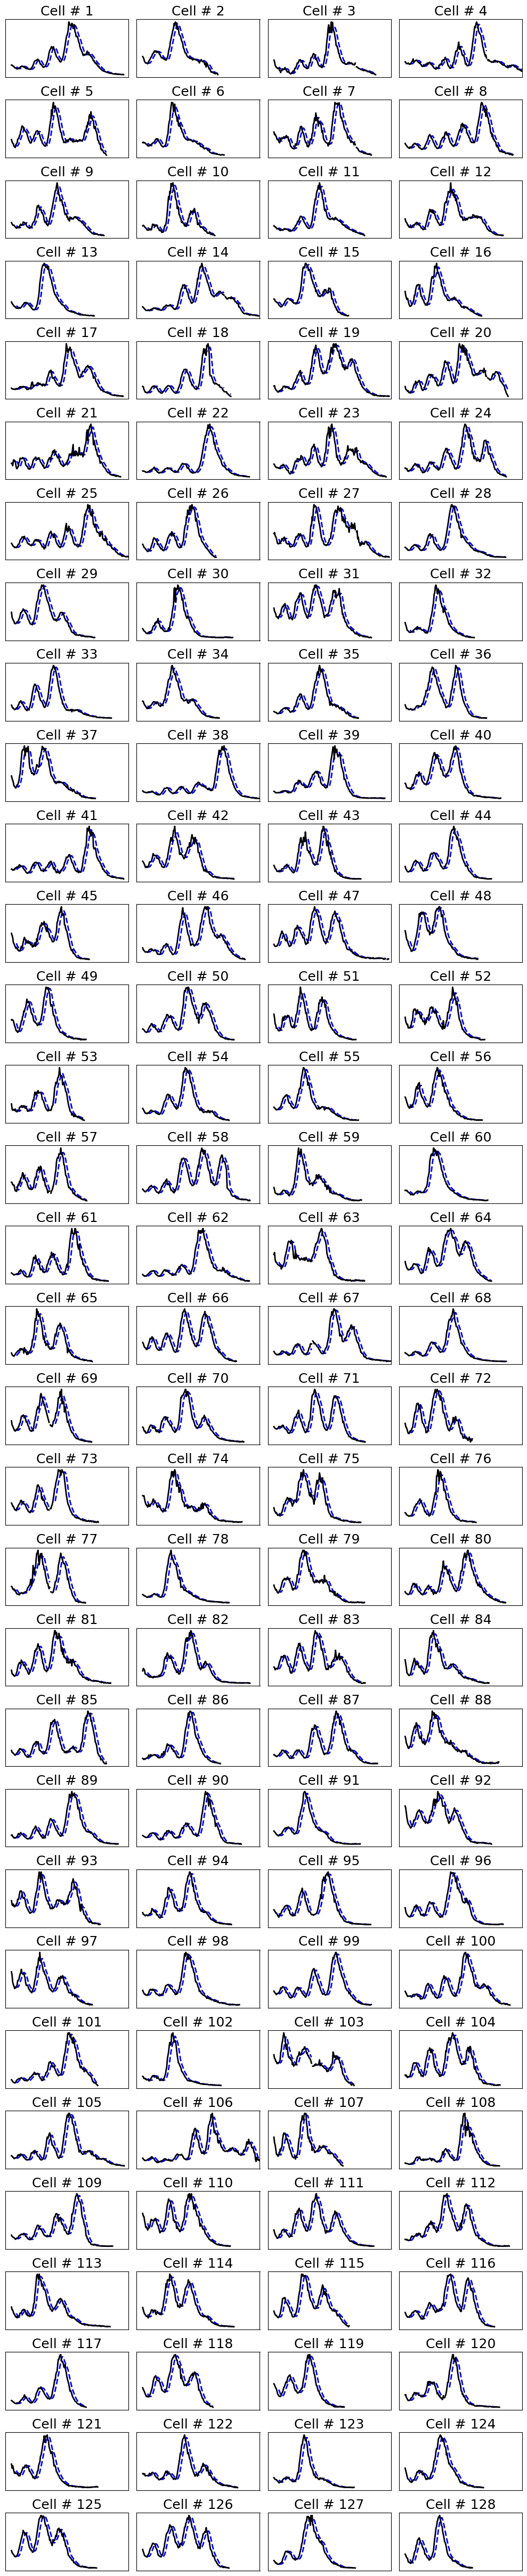

In [9]:
# Averaging window size
window = 9

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])

for j in range(n_cells):
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    # Smoothing filter
    y = smoothing_filter(tracks_save[j], window)

    plt.plot(y, color='blue',linewidth=2, linestyle = 'dashed')
    plt.plot(tracks_save[j],linewidth=2, color='black')
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    locs, labels = plt.xticks()
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0,200])

plt.tight_layout()
plt.show()

### Peak deteciton 

In [11]:
# Peak detection parameters
ind = 0 #8 
# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 8.1 # For maxima
prominence_val_ = 2 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'no_ts_as'

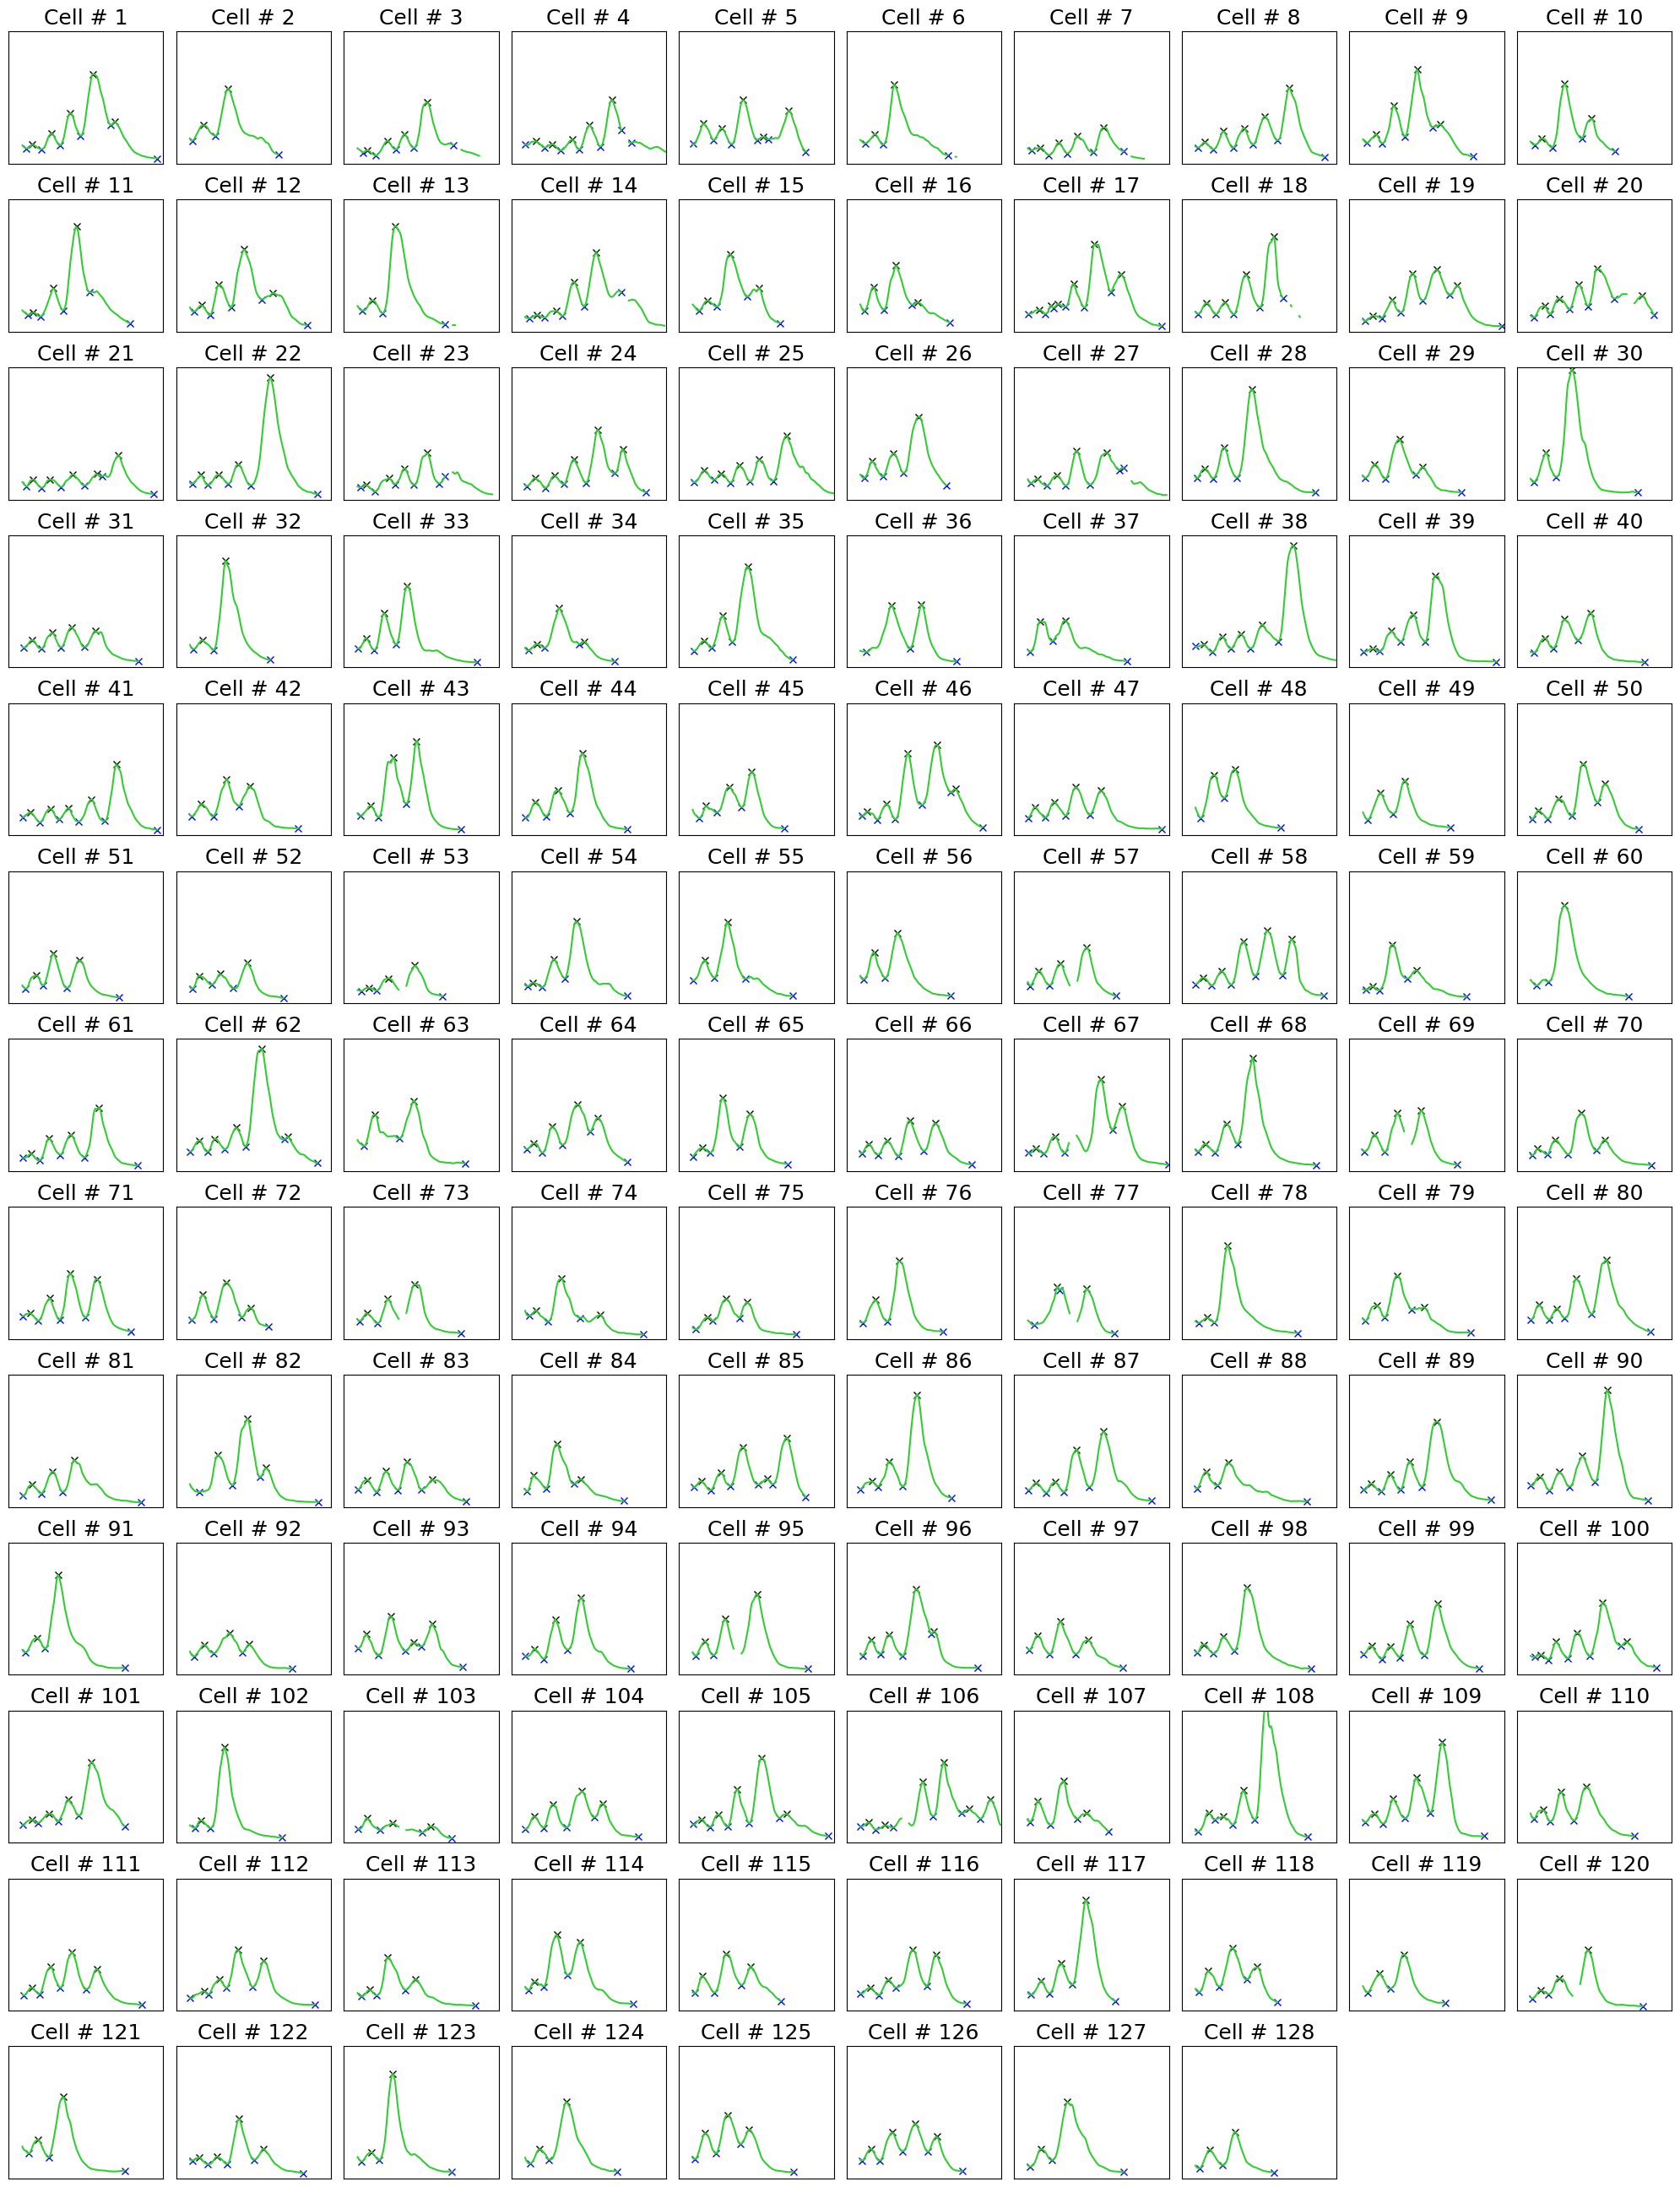

In [12]:
# Define the dimensions of the subplot
n_cols = 10
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

size_fig = n_rows*(20/n_cols)
# Initialize the figure size
fig = plt.figure(figsize=[20,size_fig])

periods = []
amplitudes = []

for j in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    if np.isnan(y[peaks.peaks_][0]):
        peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1
    
    # Save periods, amplitudes
    periods.append(np.diff(peaks.peaks))
    amplitudes.append(y[peaks.peaks])
    
    plt.plot(peaks.peaks, y[peaks.peaks], "xk"); plt.plot(peaks.peaks_, y[peaks.peaks_], "xb"); plt.plot(y, color='limegreen'); #plt.legend(['Max Peak', 'Min Peak'])
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0,200])
    plt.ylim([100,600])

plt.tight_layout()
plt.show()

#fig.savefig('../Data/Figure S2/Figure S2 - In vivo/Results/LoopinPeaksTroughs.pdf', format='pdf', bbox_inches='tight')

## Successive peak ratio vs successive amplitude ratio

In [13]:
ratio_func = lambda x: [x[i+1]/x[i] for i in range(len(x)-1)]

period_s = []
amplitudes_s = []

for i in range(n_cells):
    period_s.append(ratio_func(periods[i]))
    amplitudes_s.append(ratio_func(amplitudes[i][:-1]))

Text(0, 0.5, 'Successive Amplitude Rate')

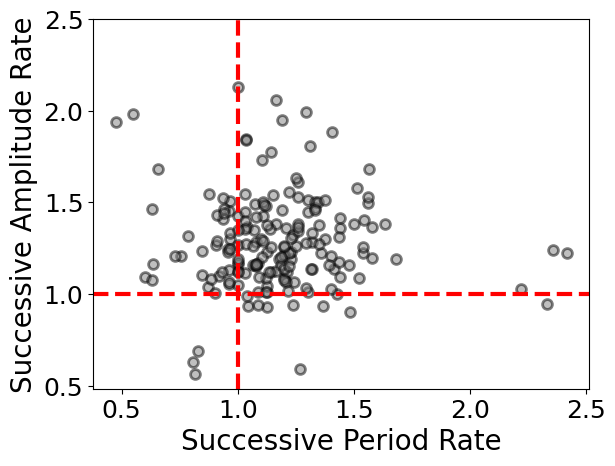

In [14]:
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='gray', s=50, linewidth=2, edgecolor='black', alpha=0.5)
        
plt.axvline(1, linewidth=3, linestyle='dashed', color='red')
plt.axhline(1, linewidth=3, linestyle='dashed', color='red')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

In [15]:
aux = []
for i in range(n_cells):
    aux.append(len(periods[i]))
    
n_peaks = np.unique(aux)

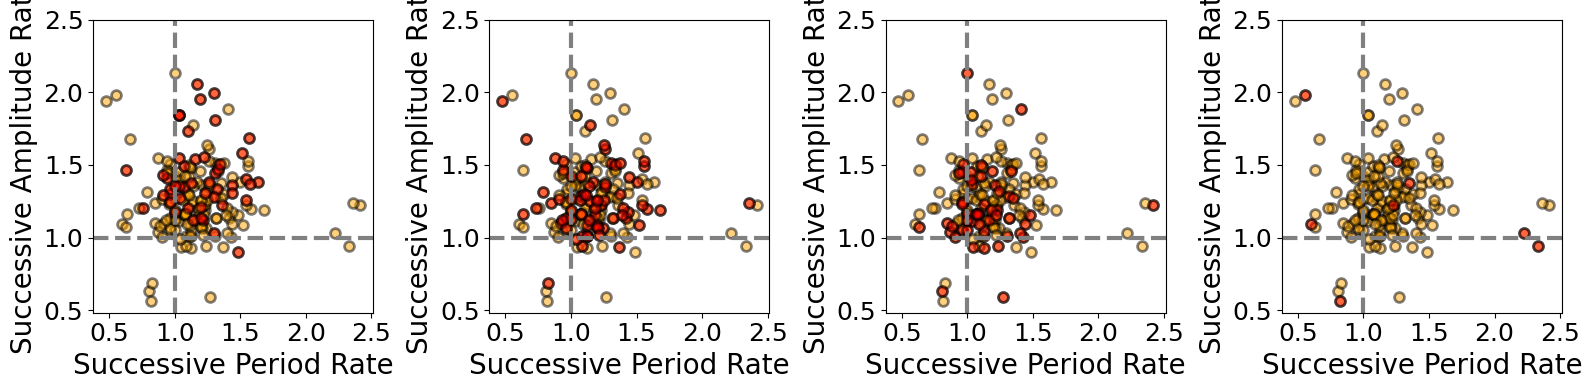

In [16]:
plt.figure(figsize=[16,4])

plt.subplot(141)
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='orange', s=50, linewidth=2, edgecolor='black', alpha=0.5)
for i in range(n_cells):
    if len(period_s[i])==1:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)


plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

plt.subplot(142)
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='orange', s=50, linewidth=2, edgecolor='black', alpha=0.5)
for i in range(n_cells):
    if len(period_s[i])==2:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)


plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

plt.subplot(143)
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='orange', s=50, linewidth=2, edgecolor='black', alpha=0.5)
for i in range(n_cells):
    if len(period_s[i])==3:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)


plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

plt.subplot(144)
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='orange', s=50, linewidth=2, edgecolor='black', alpha=0.5)
for i in range(n_cells):
    if len(period_s[i])==4:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)


plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)


plt.tight_layout()
plt.show()

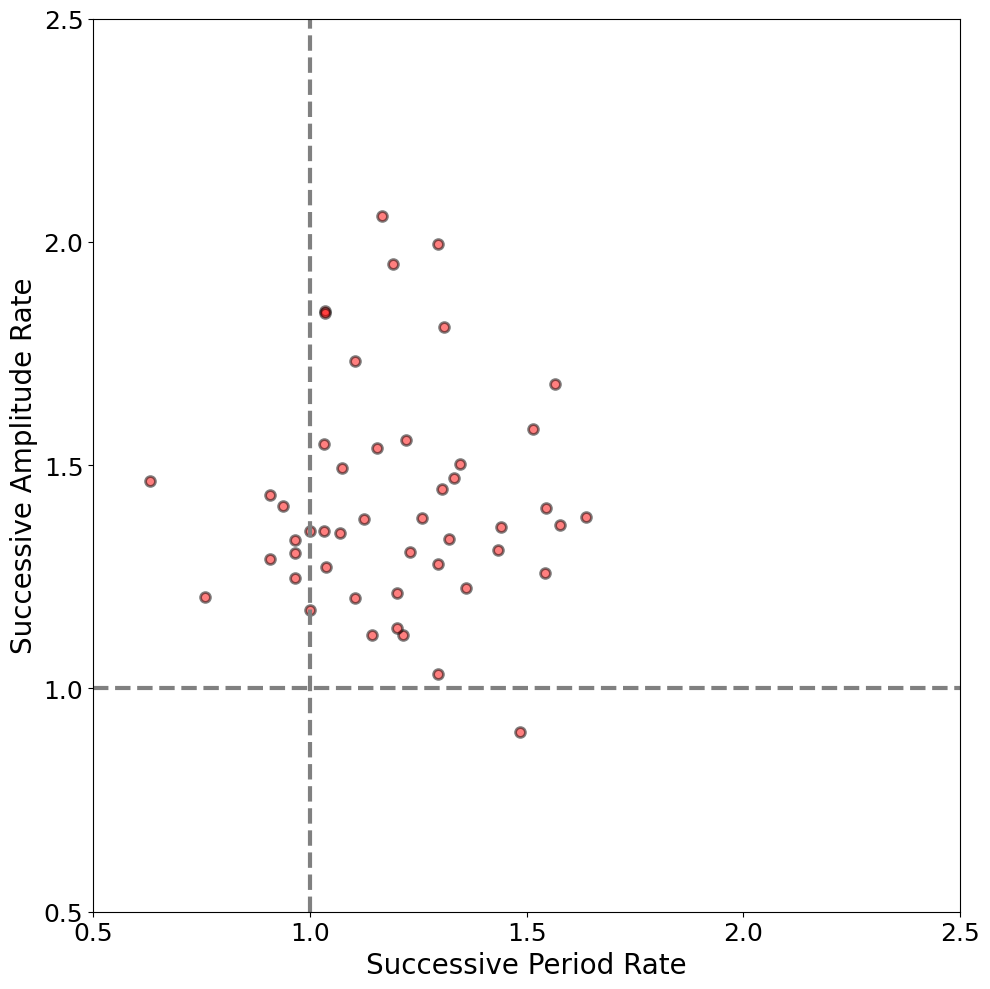

In [17]:
plt.figure(figsize=[10,10])

for i in range(n_cells):
    if len(period_s[i])==1:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)
        plt.plot(period_s[i], amplitudes_s[i], color='k')

plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

plt.tight_layout()
plt.show()

### Heatmaps

There are 4 possible options:

**[ 1 ]** Amplitude and Period successive ratio increases --> score = 1

**[ 2 ]** Amplitude and Period successive ratio decreases --> score = 2

**[ 3 ]** Amplitude successive ratio increases and the period sucessive ratio decreases --> score = 3

**[ 4 ]** Amplitude successive ratio decreases and the period successive ratio increases --> score 4

In [18]:
scores_ratios = []

for i in range(n_cells):
    aux = np.zeros(len(n_peaks)-2)
    for j in range(len(period_s[i])):
        # Add a score according to how the cells are behaving
        if period_s[i][j] > 1 and amplitudes_s[i][j] > 1:
            aux[j] = 1
        if period_s[i][j] < 1 and amplitudes_s[i][j] < 1:
            aux[j] = 2
        if period_s[i][j] > 1 and amplitudes_s[i][j] < 1:
            aux[j] = 4
        if period_s[i][j] < 1 and amplitudes_s[i][j] > 1:
            aux[j] = 3

    scores_ratios.append(aux)

/var/folders/j6/1vns_r4n3q3c74_knnjh859c0000gq/T/ipykernel_63777/3108503142.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


Text(0, 0.5, 'Number of Cells')

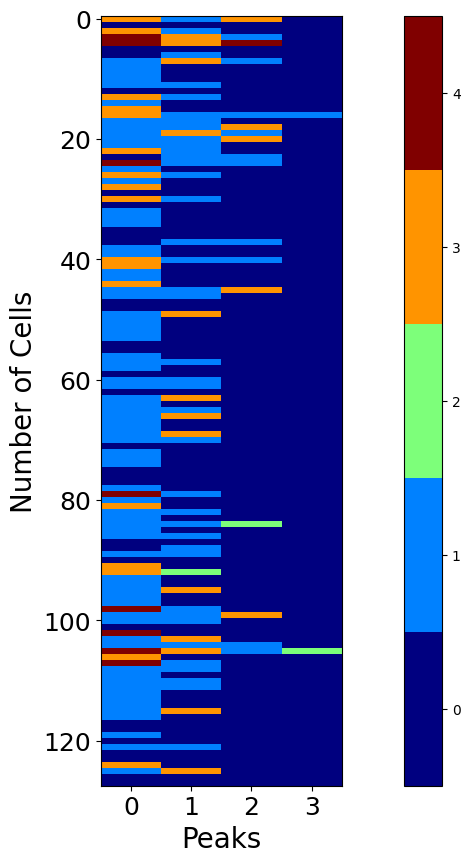

In [20]:
plt.figure(figsize=[16,10])

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

N = max(n_peaks)

plt.imshow(scores_ratios, aspect=0.1, cmap=discrete_cmap(N, 'jet'))

plt.colorbar(ticks=range(N))
plt.clim(-0.5, N - 0.5)

plt.xticks(fontsize=18)
plt.xlabel('Peaks', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Number of Cells', fontsize=20)

### Arrange the scores according to peak number

In [21]:
scores_ratios_peaks = []

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 0:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 1:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux 

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 2:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux  

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 3:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux  

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 4:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux  

/var/folders/j6/1vns_r4n3q3c74_knnjh859c0000gq/T/ipykernel_63777/3739815250.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


Text(0, 0.5, 'Number of Cells')

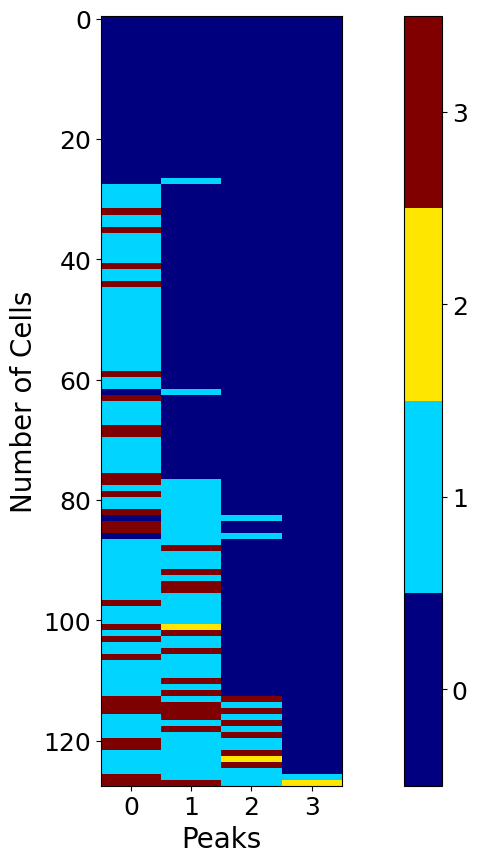

In [22]:
plt.figure(figsize=[16,10])

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

N = max(n_peaks)-1

plt.imshow(scores_ratios_peaks, aspect=0.1, cmap=discrete_cmap(N, 'jet'))

cbar = plt.colorbar(ticks=range(N))
plt.clim(-0.5, N - 0.5)
cbar.ax.tick_params(labelsize=18)

plt.xticks(fontsize=18)
plt.xlabel('Peaks', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Number of Cells', fontsize=20)

In [ ]:
DONE